In [1]:
from transformers import WhisperForConditionalGeneration
print("WhisperForConditionalGeneration is working!")

WhisperForConditionalGeneration is working!


In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

In [3]:
!pip install evaluate
!pip install jiwer

In [4]:
import evaluate
from jiwer import cer

def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

In [5]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

True
1
NVIDIA GeForce RTX 3070


In [6]:
from transformers import WhisperTokenizer, WhisperFeatureExtractor, WhisperForConditionalGeneration
import torch

# Define device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load tokenizer and feature extractor
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="spanish", task="transcribe")
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small", language="spanish", task="transcribe")

# Load model and move to appropriate device
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

Using device: cuda


In [7]:
odia_text = "Upepeténtevoi omopu'ã tapỹi tupemi ha oiko ipype ha'eño peteĩ"

tokenized_text = tokenizer(odia_text)

tokenizer.decode(tokenized_text.input_ids)

"<|startoftranscript|><|es|><|transcribe|><|notimestamps|>Upepeténtevoi omopu'ã tapỹi tupemi ha oiko ipype ha'eño peteĩ<|endoftext|>"

In [8]:
from huggingface_hub import notebook_login
notebook_login()

In [9]:
from datasets import load_dataset_builder

# Inspect dataset without downloading data
dataset_builder = load_dataset_builder(
    "mozilla-foundation/common_voice_17_0",
    "gn",
    trust_remote_code=True
)
print(dataset_builder.info.splits)
print(dataset_builder.info.features)

{'train': SplitInfo(name='train', num_bytes=903595, num_examples=1571, shard_lengths=None, dataset_name='common_voice_17_0'), 'validation': SplitInfo(name='validation', num_bytes=202017, num_examples=360, shard_lengths=None, dataset_name='common_voice_17_0'), 'test': SplitInfo(name='test', num_bytes=483369, num_examples=855, shard_lengths=None, dataset_name='common_voice_17_0'), 'other': SplitInfo(name='other', num_bytes=10875636, num_examples=18778, shard_lengths=None, dataset_name='common_voice_17_0'), 'invalidated': SplitInfo(name='invalidated', num_bytes=94160, num_examples=162, shard_lengths=None, dataset_name='common_voice_17_0'), 'validated': SplitInfo(name='validated', num_bytes=1686070, num_examples=2909, shard_lengths=None, dataset_name='common_voice_17_0')}
{'client_id': Value(dtype='string', id=None), 'path': Value(dtype='string', id=None), 'audio': Audio(sampling_rate=48000, mono=True, decode=True, id=None), 'sentence': Value(dtype='string', id=None), 'up_votes': Value(dty

In [10]:
from datasets import load_dataset,concatenate_datasets

#cv_19 = load_dataset("fsicoli/common_voice_19_0", "gn", split="train")
cv_17 = load_dataset("mozilla-foundation/common_voice_17_0", "gn", split=["train","other","test"])

In [11]:
train_data = concatenate_datasets([cv_17[0],cv_17[1]])
test_data = cv_17[2]

In [12]:
train_data[0]


{'client_id': '06ca3b22d3060995b3f4b7dd9a62eee53b8031c93cd4221342e19ed995913a9aaf1cd6fef18231d35504ea41a3f937bb2c7d31077f2baf63d0cd1aae855b7168',
 'path': 'C:\\Users\\fcent\\.cache\\huggingface\\datasets\\downloads\\extracted\\91cfc6f9f2ddb8400beedee6083cfbce0a055e71b0a82d686c25abe4e1a9abef\\gn_train_0/common_voice_gn_32418212.mp3',
 'audio': {'path': 'C:\\Users\\fcent\\.cache\\huggingface\\datasets\\downloads\\extracted\\91cfc6f9f2ddb8400beedee6083cfbce0a055e71b0a82d686c25abe4e1a9abef\\gn_train_0/common_voice_gn_32418212.mp3',
  'array': array([ 5.68434189e-14, -6.53699317e-13, -1.39266376e-12, ...,
          5.55111512e-16,  1.11022302e-16, -3.33066907e-16], shape=(235008,)),
  'sampling_rate': 48000},
 'sentence': 'Mbaʼevete ndereguerahamoʼãi koʼágui.',
 'up_votes': 2,
 'down_votes': 0,
 'age': 'thirties',
 'gender': 'male_masculine',
 'accent': '',
 'locale': 'gn',
 'segment': '',
 'variant': ''}

In [13]:
text = train_data[0]['sentence']
tok_sentence = tokenizer(text)
tok_sentence

{'input_ids': [50258, 50262, 50359, 50363, 44, 4231, 134, 120, 13379, 3498, 220, 273, 323, 2794, 260, 545, 10502, 134, 120, 1046, 72, 8384, 134, 120, 842, 2794, 72, 13, 50257], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [14]:
from IPython.display import clear_output
import time

for idx in range(len(tok_sentence.input_ids)):
    print(tokenizer.decode(tok_sentence.input_ids[:idx]))
    clear_output(wait=True)
    time.sleep(.1)

<|startoftranscript|><|es|><|transcribe|><|notimestamps|>Mbaʼevete ndereguerahamoʼãi koʼágui.


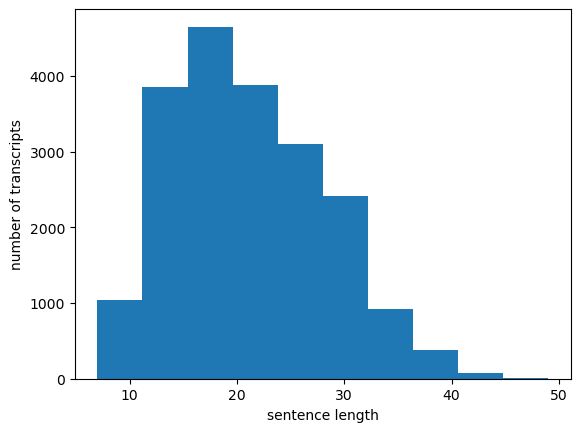

In [15]:
list_of_transcription_lengths = []

tokenized_text = tokenizer(train_data['sentence']).input_ids

for text in tokenized_text:
    list_of_transcription_lengths.append(len(text))
    # break

plt.hist(list_of_transcription_lengths)
plt.xlabel("sentence length")
plt.ylabel("number of transcripts")
plt.show()

In [16]:
import torch

for idx in range(5):

    target = train_data[idx]['sentence']
    audio_original = train_data[idx]['audio']['array']
    original_sample_rate = train_data[idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='spanish', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


-------0------
true : Mbaʼevete ndereguerahamoʼãi koʼágui. 
pred :  Va a ir a ver a la casa de la hija.

 
-------1------
true : Heta rehasa'asýkuri. 
pred :  Heta reha sa sukuri

 
-------2------
true : térã katu oñemonge. 
pred :  Te he nacido ayer conmigo.

 
-------3------
true : Oĩ ombotýva hesa, omañáva yvate, ambuévakatu yvýre. 
pred :  Hoy, un botúo esa, o mañana ovate, amboeva, cato, uvude.

 
-------4------
true : Tani oho gua'i retãme. 
pred :  Tani ojo wa ire tame.

 


In [17]:

class whisper_training_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):#daatset is huggingface dataset object
        self.dataset = dataset
        self.max_len = max_len
        self.bos_token = model.config.decoder_start_token_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        audio_data = down_sample_audio(item['audio']["array"], item['audio']["sampling_rate"])
        input_features = feature_extractor(audio_data, sampling_rate=16000,return_tensors='pt').input_features[0]

        # Process the transcription
        transcription = item["sentence"]

        # Create labels
        labels = tokenizer(transcription, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)
        labels = labels[0][1:]


        return {
            "input_features": input_features,
            "labels": labels
        }

In [18]:
dataset = whisper_training_dataset(dataset=train_data, max_len=300)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,  # Adjust batch size as needed
    shuffle=False,  # Shuffle data during training
)

### New implementation of "evaluate()"
Let see if itt works

In [19]:
import jiwer  # Ensure jiwer is imported

def evaluation(model):
    torch.cuda.empty_cache() # clean training graph memory
    
    device = 'cuda'

    # Prepare test dataset and dataloader
    test_dataset = whisper_training_dataset(dataset=test_data, max_len=300)

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,  # Adjust batch size as needed
        shuffle=False,  #  Disable shuffling for consistent evaluation
        pin_memory=True, # Faster CPU-to-GPU transfer
    )

    model.eval()

    predictions = []
    references = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            # Note: Remove model.train() as it contradicts model.eval()
            input_features = batch["input_features"].to(device, non_blocking=True)
            labels = batch["labels"].to(device, non_blocking=True)
            
            generated_tokens = model.generate(
                input_features=input_features, 
                language='spanish', 
                task='transcribe'
            )

            # Decode predictions and references
            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
            
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)

    # Correct WER calculation using jiwer.wer
    WER = jiwer.wer(references, predictions) * 100  # Note: references first, then predictions

    return WER

In [20]:
# WER before the training
torch.cuda.empty_cache()
evaluation(model)

100%|████████████████████████████████████████████████████████████████████████████████| 855/855 [07:13<00:00,  1.97it/s]


230.63469675599438

In [21]:
save_directory = "finetuned_whisper-gn"

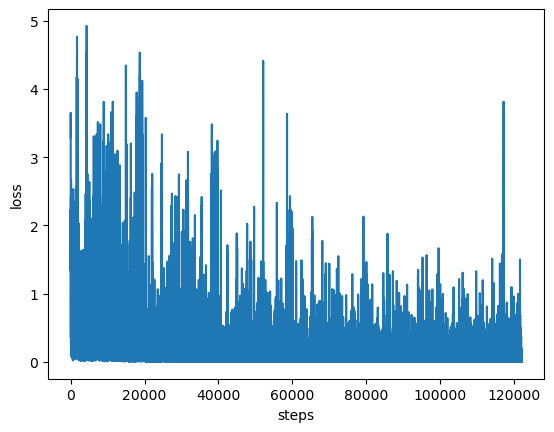

100%|████████████████████████████████████████████████████████████████████████████████| 855/855 [06:30<00:00,  2.19it/s]


Epoch 6 - Validation WER: 9.48%
New best WER: 9.48%. Saving model...


In [22]:
from IPython.display import clear_output
from torch.cuda.amp import autocast, GradScaler

torch.cuda.empty_cache()

model.train()
device='cuda'
optimizer=torch.optim.AdamW(model.parameters(), lr=1e-5)
# optimizer=torch.optim.AdamW(requires_grad_params, lr=5e-4) # Only for LoRA Training

max_epochs=6

# To evaluate results after each epoch and stop erarly if needed
best_wer = float('inf')
patience_epochs = 3 # Stop if no improvement after 3 epochs
epochs_without_improvement = 0

running_wer=[]
running_loss=[]

scaler = GradScaler()

for epoch in range(max_epochs):
    print("Epoch:", epoch, "/", max_epochs)
    model.train()  # Set model to training mode

    for batch in tqdm(train_dataloader,total=len(train_dataloader),leave=False):

        input_features = batch["input_features"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)
        # Forward pass
        #outputs = model(input_features, labels=labels)  # Assuming your model takes these inputs

        optimizer.zero_grad()

        with autocast():
            outputs = model(input_features, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss.append(loss.item())

        if len(running_loss) % 50 ==0:  # Print loss every 50 batches
            plt.plot(running_loss)
            plt.xlabel('steps')
            plt.ylabel('loss')
            clear_output(wait=True)  # Clear the output to keep the plot clean
            plt.show()

        if len(running_loss) % 100 == 0:  # Save model every 100 steps
            # torch.save(model.state_dict(), f'finetuned_on_odia_steps_{len(running_loss)}.pth')
            model.save_pretrained('lora_model')

    # Evaluate after each epoch
    torch.cuda.empty_cache()
    current_wer = evaluation(model)
    running_wer.append(current_wer)
    
    print(f"Epoch {epoch + 1} - Validation WER: {current_wer:.2f}%")

    if current_wer < best_wer:
        best_wer = current_wer
        epochs_without_improvement = 0
        print(f"New best WER: {best_wer:.2f}%. Saving model...")
        model.save_pretrained(save_directory) # Save the best model
        tokenizer.save_pretrained(save_directory)
        feature_extractor.save_pretrained(save_directory)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience_epochs:
        print(f"No improvement in WER for {patience_epochs} epochs. Stopping early.")
        break



In [23]:
import torch
from transformers import WhisperForConditionalGeneration, WhisperTokenizer, WhisperFeatureExtractor
from huggingface_hub import HfApi, HfFolder, notebook_login

# --- Make sure you are logged in ---
# If you haven't run notebook_login() and logged in yet, do it now:
# notebook_login()

# --- Ensure your model is on the CPU before saving (optional but good practice) ---
# model.to('cpu')

# --- Define your desired repository name ---
# Replace 'your-username' with your actual Hugging Face username
# and 'your-model-name' with a descriptive name for your model.
repo_name = "SchindleriaPraematurus/whisper-tiny-gn-finetuned"

# --- Push everything to the Hub ---
print(f"Pushing model to {repo_name}...")
model.push_to_hub(repo_name, commit_message="Upload fine-tuned Whisper-tiny for Guarani (gn)")

print(f"Pushing tokenizer to {repo_name}...")
tokenizer.push_to_hub(repo_name, commit_message="Upload tokenizer")

print(f"Pushing feature extractor to {repo_name}...")
feature_extractor.push_to_hub(repo_name, commit_message="Upload feature_extractor")

print("All components pushed to the Hugging Face Hub successfully!")

# You can move the model back to GPU if you want to continue using it
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model.to(device)

Pushing model to SchindleriaPraematurus/whisper-tiny-gn-finetuned...


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

C:\Users\fcent\anaconda3\envs\whisper-env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\fcent\.cache\huggingface\hub\models--SchindleriaPraematurus--whisper-tiny-gn-finetuned. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

Pushing tokenizer to SchindleriaPraematurus/whisper-tiny-gn-finetuned...


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Pushing feature extractor to SchindleriaPraematurus/whisper-tiny-gn-finetuned...


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

All components pushed to the Hugging Face Hub successfully!


In [61]:
# Load model
model = WhisperForConditionalGeneration.from_pretrained("finetuned_whisper-gn")
tokenizer = WhisperTokenizer.from_pretrained("finetuned_whisper-gn")
feature_extractor = WhisperFeatureExtractor.from_pretrained("finetuned_whisper-gn")

model.to('cuda')
model.eval()

# Override the model’s default generation config
model.generation_config.forced_decoder_ids = None
model.generation_config.language = "spanish"
model.generation_config.task = "transcribe"

In [62]:
model.eval()

test_data = load_dataset("mozilla-foundation/common_voice_17_0", "gn", split="test")

for idx in range(5):

    target = test_data[idx]['sentence']
    audio_original = test_data[idx]['audio']['array']
    original_sample_rate = test_data[idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), generation_config=gen_config)


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

-------0------
true : omba'apóva ñanduti iporãve hag̃ua 
pred : omba'apóva ñanduti iporãve hag̃ua

 
-------1------
true : Ñúme katu ynambu oĩva'ekue. 
pred : Ñúme katu ynambu oĩva'ekue.

 
-------2------
true : Heta ára ndaje ohasa asy. 
pred : Heta ára ndaje ohasa asy.

 
-------3------
true : ¡Pepracticavéke! 
pred : ¡Pepracticavéke!

 
-------4------
true : sa'íma oĩ ka'aguy 
pred : sa'íma oĩ ka'aguy

 


In [66]:
from transformers import pipeline

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    chunk_length_s=30,     # 30s chunks
    stride_length_s=10,    # 10s overlap
    device='cuda',
)


Device set to use cuda


In [69]:
file_path = "padrehijo.mp3"
result = pipe(file_path)
result

{'text': "Ambyakuhína che ry'o apy'a héta nde peteĩ he'i aýpe."}